<a href="https://colab.research.google.com/github/porori1224/2024_Chosun_osp_Deepfake-detection-Challenge/blob/main/KMS_Try_Code/After_2nd_Mentoring_all_%EC%86%8D%EB%8F%84_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
# check the current path
print(os.getcwd()) # /content

# You should copy the path : 왼쪽 폴더에서 오른쪽 버튼 후 경로복사
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW')

print(os.getcwd()) # path has been changed

/content
/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW


In [3]:
!pip install retina-face

In [4]:
!pip install torch torchvision torchaudio

In [5]:
# 필요시 설치
!pip install scikit-learn matplotlib

In [6]:
!pip install timm

In [51]:
import pandas as pd
import json

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01"
folders = ["dfdc_train_part_0", "dfdc_train_part_1"]
output_dir = os.path.join(base_dir, "processed_videos")
os.makedirs(output_dir, exist_ok=True)

# 데이터프레임 초기화
combined_df = pd.DataFrame()

# 각 폴더에서 데이터를 읽고 합치기
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    json_file = os.path.join(folder_path, "metadata.json")

    # JSON 파일 로드
    with open(json_file, "r") as f:
        metadata = json.load(f)

    # JSON 데이터를 DataFrame으로 변환
    df = pd.DataFrame.from_dict(metadata, orient="index").reset_index()
    df.columns = ["filename", "label", "split", "original"]
    df["label"] = df["label"].map({"FAKE": 0, "REAL": 1})

    # 파일 경로 추가
    df["filepath"] = df["filename"].apply(lambda x: os.path.join(folder_path, x))

    # 데이터프레임 병합
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# 병합 결과 확인
print(f"Total videos in combined dataset: {len(combined_df)}")
print(combined_df["label"].value_counts())

# 데이터 저장 (원한다면 Pickle로 저장)
combined_pickle_path = os.path.join(base_dir, "combined_metadata.pkl")
combined_df.to_pickle(combined_pickle_path)
print(f"Combined metadata saved to: {combined_pickle_path}")

Total videos in combined dataset: 3033
label
0    2839
1     194
Name: count, dtype: int64
Combined metadata saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/combined_metadata.pkl


In [52]:
# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame.from_dict(metadata, orient="index").reset_index()
df.columns = ["filename", "label", "split", "original"]

# 라벨링을 0과 1로 매핑
label_mapping = {"FAKE": 0, "REAL": 1}
df["label"] = df["label"].map(label_mapping)

# 매핑되지 않은 라벨 확인 및 처리
if df["label"].isnull().any():
    print("Warning: Some labels were not mapped correctly.")
    unmapped_labels = df[df["label"].isnull()]
    print(f"Unmapped labels:\n{unmapped_labels}")
    # unmapped_labels를 기록하거나, 원하는 디폴트 값으로 설정 가능
    df["label"] = df["label"].fillna(-1)  # 예: -1로 설정

In [53]:
# 데이터프레임에서 필요한 컬럼만 출력하도록 정리
print(f"Total data size: {len(df)}")
print(df[["filename", "label", "split", "original"]].head(10))

# 경로 설정
base_dir_0 = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0"
base_dir_1 = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_1"

# 경로 설정 함수 생성 (폴더 선택 로직)
def determine_base_dir(filename):
    if filename in os.listdir(base_dir_0):
        return os.path.join(base_dir_0, filename)
    elif filename in os.listdir(base_dir_1):
        return os.path.join(base_dir_1, filename)
    else:
        return None  # 파일이 존재하지 않을 경우

# 비디오 파일 경로 생성
df["filepath"] = df["filename"].apply(determine_base_dir)

# 경로가 존재하지 않는 파일 확인 및 출력
missing_files = df[df["filepath"].isnull()]
if not missing_files.empty:
    print(f"Warning: {len(missing_files)} files are missing:")
    print(missing_files[["filename"]])

Total data size: 1699
         filename  label  split        original
0  zumqqvixhu.mp4      0  train  hntguogkqd.mp4
1  utdlsqfykm.mp4      0  train  nswtvttxre.mp4
2  mdfndlljvt.mp4      0  train  ptkcmwnfjv.mp4
3  maktypgsfl.mp4      0  train  objgwnmscm.mp4
4  pleqihjpif.mp4      0  train  xrhqtmxlvx.mp4
5  yejvlyggtw.mp4      0  train  mwwploizlj.mp4
6  yotsfuryir.mp4      0  train  dvwpvqdflx.mp4
7  tguqyatciq.mp4      0  train  lujvyveojc.mp4
8  fjzrvkleur.mp4      0  train  gylcfcozce.mp4
9  kylqyoxeqm.mp4      0  train  zwswwwrefl.mp4


In [14]:
import os
import pandas as pd
import json
import cv2
from retinaface import RetinaFace
from multiprocessing import Pool
from torchvision import transforms
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle


# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
input_dirs = [
    os.path.join(base_dir, "00~01/dfdc_train_part_0"),
    os.path.join(base_dir, "00~01/dfdc_train_part_1")
]
output_dir = os.path.join(base_dir, "processed_videos00")
os.makedirs(output_dir, exist_ok=True)

# 비디오 처리 함수
skipped_videos = set()  # 중복 방지
data_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

def process_video(video_info):
    video_path, output_path = video_info
    try:
        # 비디오 열기
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Skipping invalid video: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 프레임 읽기
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid_frame_idx = frame_count // 2
        random_frame_idx = random.randint(0, frame_count - 1)
        selected_frames = [mid_frame_idx, random_frame_idx]

        frames = []
        for idx in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            if idx in selected_frames:
                frames.append(frame)
        cap.release()

        if not frames:
            print(f"No frames selected: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 얼굴 감지 및 데이터 증강
        for frame in frames:
            resized_frame = cv2.resize(frame, (160, 90))  # 해상도 축소
            faces = RetinaFace.detect_faces(resized_frame)
            if isinstance(faces, dict) and faces:
                bbox = list(faces.values())[0]["facial_area"]
                cropped_face = resized_frame[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # 데이터 증강
                augmented_face = data_augment(cropped_face)

                # 이미지 저장
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                augmented_image = transforms.ToPILImage()(augmented_face)
                augmented_image.save(output_path)
                print(f"Processed and saved: {output_path}")
                return output_path

        print(f"Skipping video without detectable faces: {video_path}")
        skipped_videos.add(video_path)
        return None

    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        skipped_videos.add(video_path)
        return None

# 비디오 정보 리스트 생성
video_info_list = []
for input_dir in input_dirs:
    video_info_list.extend([
        (os.path.join(input_dir, filename), os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_processed.jpg"))
        for filename in os.listdir(input_dir) if filename.endswith(".mp4")
    ])

# 병렬 처리 함수
def process_videos_in_parallel(video_info_list, num_processes=os.cpu_count()):
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_video, video_info_list)
    return results

# 실행
if __name__ == "__main__":
    print("Starting optimized video processing...")
    processed_files = process_videos_in_parallel(video_info_list, num_processes=4)
    print("Processing complete.")

    # 스킵된 비디오 저장
    skipped_videos_path = os.path.join(base_dir, "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/skipped_videos.txt")
    with open(skipped_videos_path, "w") as f:
        for video in skipped_videos:
            f.write(f"{video}\n")
    print(f"Skipped videos saved to: {skipped_videos_path}")

Starting optimized video processing...
24-12-02 17:39:26 - Directory /root/.deepface created24-12-02 17:39:26 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h524-12-02 17:39:26 - Directory /root/.deepface/weights created

24-12-02 17:39:26 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
24-12-02 17:39:26 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5

24-12-02 17:39:26 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
Downloading...
From:From:  https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5Downloading...


From:To: /root/.deepface/weights/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
 https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
  0%|          | 0.00/119M [00:00<?, ?B/s]Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 275MB/s]
100%|██████████| 119M/119M [00:00<00:00, 270MB/s]
100%|██████████| 119M/119M [00:00<00:00, 251MB/s] 
100%|██████████| 119M/119M [00:00<00:00, 250MB/s] 


Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/kstmekinaw_processed.jpg
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/wdcrhqtjhf.mp4
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/wbdpryfqgy.mp4
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/yajhwipypq_processed.jpg
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/lljlzhmrhp.mp4
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/ygngdbjmox_processed.jpg
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/fzkzqwoghs_processed.jpg
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/culaevxduf.mp4
Skipping vid

In [71]:
# 처리된 데이터 개수 확인 및 출력
print(f"Total processed videos: {len(processed_files)}")

Total processed videos: 2734


In [72]:
print(f"Skipped videos set: {skipped_videos}")

Skipped videos set: []


In [73]:
# 스킵된 비디오 로그 확인
skipped_videos_path = os.path.join(base_dir, "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/skipped_videos.txt")
with open(skipped_videos_path, "r") as f:
    skipped_videos = f.readlines()
print(f"Skipped videos: {len(skipped_videos)}")
print(f"Sample skipped videos: {skipped_videos[:5]}")

Skipped videos: 0
Sample skipped videos: []


In [74]:
import os
import pandas as pd

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
processed_dir = os.path.join(base_dir, "processed_videos00")
skipped_videos_path = os.path.join(base_dir, "skipped_videos.txt")

# 처리된 파일 로드
processed_files = os.listdir(processed_dir)
print(f"Total processed files: {len(processed_files)}")
print(f"Sample processed files: {processed_files[:5]}")

# 스킵된 비디오 로드
with open(skipped_videos_path, "r") as f:
    skipped_videos = f.readlines()
skipped_videos = [x.strip() for x in skipped_videos]
print(f"Total skipped videos: {len(skipped_videos)}")
print(f"Sample skipped videos: {skipped_videos[:5]}")

Total processed files: 2734
Sample processed files: ['smxqivzwed_processed.jpg', 'atzwrsivnb_processed.jpg', 'tktsmomimq_processed.jpg', 'mrovsdlffg_processed.jpg', 'kihrpdtbwy_processed.jpg']
Total skipped videos: 0
Sample skipped videos: []


In [75]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
input_dirs = [
    os.path.join(base_dir, "00~01/dfdc_train_part_0"),
    os.path.join(base_dir, "00~01/dfdc_train_part_1")
]
output_dir = os.path.join(base_dir, "processed_videos00")
os.makedirs(output_dir, exist_ok=True)

# JSON 파일 로드 및 결합
dataframes = []
for input_dir in input_dirs:
    json_path = os.path.join(input_dir, "metadata.json")
    with open(json_path, "r") as f:
        metadata = pd.DataFrame.from_dict(json.load(f), orient="index").reset_index()
    metadata.columns = ["filename", "label", "split", "original"]
    metadata["label"] = metadata["label"].map({"FAKE": 0, "REAL": 1})
    metadata["filepath"] = metadata["filename"].apply(lambda x: os.path.join(input_dir, x))
    dataframes.append(metadata)

# 두 데이터프레임 결합
df = pd.concat(dataframes, ignore_index=True)

# 데이터 균형 확인 및 조정
fake_df = df[df["label"] == 0]
real_df = df[df["label"] == 1]

if len(real_df) == 0 or len(fake_df) == 0:
    raise ValueError("Either the REAL or FAKE dataset is empty. Please check your dataset.")

# Fake 데이터를 Real 데이터 크기에 맞게 샘플링
fake_sampled = resample(fake_df, replace=False, n_samples=len(real_df), random_state=42)
balanced_df = pd.concat([real_df, fake_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터 크기 확인
print(f"Filtered and balanced DataFrame size: {len(balanced_df)}")
print("Class distribution after balancing:")
print(balanced_df["label"].value_counts())

# 데이터 분리 (80% Train + Validation, 20% Test)
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df["label"]
)

# Train과 Validation 데이터 분리 (Train: 80%, Validation: 20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df["label"]
)

# Split 열 업데이트
train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

# 분리된 데이터 크기 확인
print("\nData splits:")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# 클래스별 데이터 크기 확인
print("\nClass distribution:")
print(f"Train:\n{train_df['label'].value_counts()}")
print(f"Validation:\n{val_df['label'].value_counts()}")
print(f"Test:\n{test_df['label'].value_counts()}")

# Pickle 저장 경로
train_pickle_path = os.path.join(base_dir, "train_split.pkl")
val_pickle_path = os.path.join(base_dir, "val_split.pkl")
test_pickle_path = os.path.join(base_dir, "test_split.pkl")

# Pickle 저장
pickle_paths = {"Train": train_pickle_path, "Validation": val_pickle_path, "Test": test_pickle_path}
datasets = {"Train": train_df, "Validation": val_df, "Test": test_df}

for split, path in pickle_paths.items():
    with open(path, "wb") as f:
        pickle.dump(datasets[split], f)
    print(f"{split} data saved to: {path}")

Filtered and balanced DataFrame size: 388
Class distribution after balancing:
label
0    194
1    194
Name: count, dtype: int64

Data splits:
Train size: 248
Validation size: 62
Test size: 78

Class distribution:
Train:
label
1    124
0    124
Name: count, dtype: int64
Validation:
label
1    31
0    31
Name: count, dtype: int64
Test:
label
0    39
1    39
Name: count, dtype: int64
Train data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/train_split.pkl
Validation data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/val_split.pkl
Test data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/test_split.pkl


In [44]:
from sklearn.utils import resample
import os
import pandas as pd

# 파일명과 라벨 매핑 생성 함수
def create_labels(df, processed_files):
    """
    주어진 데이터프레임과 처리된 파일 목록을 바탕으로 {파일명: 라벨} 형태의 매핑 생성
    """
    labels = {}
    for filename, label in zip(df["filename"], df["label"]):
        base_filename = os.path.splitext(filename)[0]
        processed_filename = f"{base_filename}_processed.jpg"
        if processed_filename in processed_files:
            labels[processed_filename] = label
    return labels

# 처리된 파일 예제
processed_files = set([f"video_{i}_processed.jpg" for i in range(1000)])  # 예제 데이터

# 파일명과 라벨 매핑 생성
train_labels = create_labels(balanced_train_df, processed_files)
val_labels = create_labels(balanced_val_df, processed_files)
test_labels = create_labels(balanced_test_df, processed_files)

# Split 열 업데이트 (중복 방지)
for df, split in zip([train_df, val_df, test_df], ["train", "validation", "test"]):
    df["split"] = split

# 출력으로 데이터 크기 확인
print("\nBalanced Data Distribution:")
print(f"Train size: {len(balanced_train_df)} (Classes: {balanced_train_df['label'].value_counts().to_dict()})")
print(f"Validation size: {len(balanced_val_df)} (Classes: {balanced_val_df['label'].value_counts().to_dict()})")
print(f"Test size: {len(balanced_test_df)} (Classes: {balanced_test_df['label'].value_counts().to_dict()})")

print("\nExample Labels (Train):", list(train_labels.items())[:5])


Balanced Data Distribution:
Train size: 248 (Classes: {1: 124, 0: 124})
Validation size: 62 (Classes: {0: 31, 1: 31})
Test size: 78 (Classes: {1: 39, 0: 39})

Example Labels (Train): []


In [77]:
import os
import pandas as pd
import pickle

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
train_pickle_path = os.path.join(base_dir, "train_split.pkl")
val_pickle_path = os.path.join(base_dir, "val_split.pkl")
test_pickle_path = os.path.join(base_dir, "test_split.pkl")

# Pickle 파일 로드 함수
def load_pickle(file_path):
    """
    주어진 파일 경로에서 Pickle 파일을 로드합니다.
    """
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            return pickle.load(f)
    else:
        print(f"Error: {file_path} does not exist.")
        return None

# 데이터 로드
train_df = load_pickle(train_pickle_path)
val_df = load_pickle(val_pickle_path)
test_df = load_pickle(test_pickle_path)

# 데이터 로드 결과 확인
if train_df is not None and val_df is not None and test_df is not None:
    # 데이터 크기 및 라벨 분포 확인
    print(f"\nTrain DataFrame size: {len(train_df)}")
    print(f"Validation DataFrame size: {len(val_df)}")
    print(f"Test DataFrame size: {len(test_df)}")

    print("\nLabel distribution in Train Data:")
    print(train_df["label"].value_counts())

    print("\nLabel distribution in Validation Data:")
    print(val_df["label"].value_counts())

    print("\nLabel distribution in Test Data:")
    print(test_df["label"].value_counts())

    # 데이터 샘플 확인
    print("\nTrain DataFrame Sample:")
    print(train_df[["filename", "label", "split", "filepath"]].head())

    print("\nValidation DataFrame Sample:")
    print(val_df[["filename", "label", "split", "filepath"]].head())

    print("\nTest DataFrame Sample:")
    print(test_df[["filename", "label", "split", "filepath"]].head())

    # 처리된 비디오 파일 확인
    processed_dir = os.path.join(base_dir, "processed_videos00")
    if os.path.exists(processed_dir):
        processed_files = os.listdir(processed_dir)
        print(f"\nTotal processed video files: {len(processed_files)}")
        print(f"Sample processed files: {processed_files[:5]}")
    else:
        print(f"Error: Processed directory '{processed_dir}' does not exist.")
        processed_files = []

    # 처리된 파일이 Pickle 데이터와 매핑되는지 확인
    if processed_files:
        mapped_files = train_df["filepath"].apply(lambda x: os.path.basename(x)).tolist()
        unmatched_files = set(mapped_files) - set(processed_files)
        print(f"\nUnmatched files in Train Data: {len(unmatched_files)}")
        if unmatched_files:
            print(f"Unmatched file samples: {list(unmatched_files)[:5]}")
        else:
            print("All files in Train Data are correctly processed and mapped.")
else:
    print("Error: One or more Pickle files failed to load. Please check your file paths.")


Train DataFrame size: 248
Validation DataFrame size: 62
Test DataFrame size: 78

Label distribution in Train Data:
label
1    124
0    124
Name: count, dtype: int64

Label distribution in Validation Data:
label
1    31
0    31
Name: count, dtype: int64

Label distribution in Test Data:
label
0    39
1    39
Name: count, dtype: int64

Train DataFrame Sample:
           filename  label  split  \
301  mwwploizlj.mp4      1  train   
223  puhybjenqt.mp4      0  train   
198  jawgcggquk.mp4      1  train   
91   yskcbgayhp.mp4      0  train   
136  nrnklcxdzq.mp4      1  train   

                                              filepath  
301  /content/gdrive/MyDrive/Colab Notebooks/KMS_OS...  
223  /content/gdrive/MyDrive/Colab Notebooks/KMS_OS...  
198  /content/gdrive/MyDrive/Colab Notebooks/KMS_OS...  
91   /content/gdrive/MyDrive/Colab Notebooks/KMS_OS...  
136  /content/gdrive/MyDrive/Colab Notebooks/KMS_OS...  

Validation DataFrame Sample:
           filename  label       split  \
18

In [78]:
# Train 데이터와 처리된 파일 매칭 검증
mapped_files = train_df["filename"].apply(lambda x: os.path.splitext(x)[0] + "_processed.jpg").tolist()
unmatched_files = set(mapped_files) - set(processed_files)
print(f"\nUnmatched files in Train Data after fix: {len(unmatched_files)}")
if unmatched_files:
    print(f"Unmatched file samples: {list(unmatched_files)[:5]}")
else:
    print("All files in Train Data are correctly processed and mapped.")


Unmatched files in Train Data after fix: 21
Unmatched file samples: ['aayrffkzxn_processed.jpg', 'uqtqhiqymz_processed.jpg', 'mphsgertmm_processed.jpg', 'omizcfnsic_processed.jpg', 'yzuestxcbq_processed.jpg']


Train dataset size: 227
Validation dataset size: 60
Test dataset size: 76
Training Ensemble Model...


Epoch 1/10: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


Epoch 1/10 - Train Loss: 0.6968


Epoch 2/10: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Epoch 2/10 - Train Loss: 0.6233


Epoch 3/10: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Epoch 3/10 - Train Loss: 0.5714


Epoch 4/10: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


Epoch 4/10 - Train Loss: 0.4881


Epoch 5/10: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


Epoch 5/10 - Train Loss: 0.3670


Epoch 6/10: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Epoch 6/10 - Train Loss: 0.2809


Epoch 7/10: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Epoch 7/10 - Train Loss: 0.2240


Epoch 8/10: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Epoch 8/10 - Train Loss: 0.1434


Epoch 9/10: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Epoch 9/10 - Train Loss: 0.1158


Epoch 10/10: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Epoch 10/10 - Train Loss: 0.0899


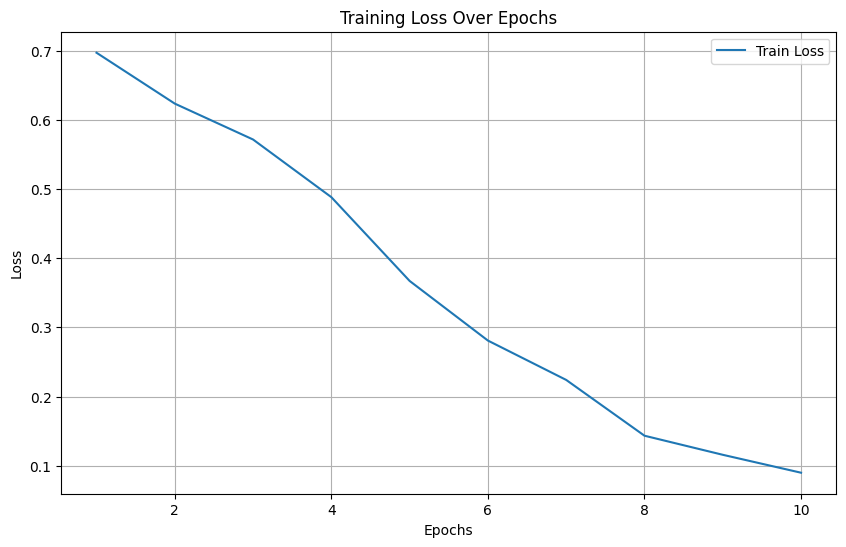

In [79]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# 경로 설정
processed_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00"
train_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/train_split.pkl"
val_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/val_split.pkl"
test_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/test_split.pkl"

# Pickle 파일에서 데이터프레임 로드
import pickle
with open(train_pickle_path, "rb") as f:
    train_df = pickle.load(f)
with open(val_pickle_path, "rb") as f:
    val_df = pickle.load(f)
with open(test_pickle_path, "rb") as f:
    test_df = pickle.load(f)

# 데이터셋 클래스 정의
class ProcessedDataset(Dataset):
    def __init__(self, image_dir, labels, transform=None):
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform
        self.image_files = []
        self.filtered_labels = {}

        for image_file, label in labels.items():
            image_path = os.path.join(self.image_dir, image_file)
            if os.path.exists(image_path):  # 파일이 존재하는지 확인
                self.image_files.append(image_file)
                self.filtered_labels[image_file] = label

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label = self.filtered_labels[image_file]
        image_path = os.path.join(self.image_dir, image_file)

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# 이미지 전처리(transformations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 DataLoader 생성
train_dataset = ProcessedDataset(processed_dir, train_labels, transform=transform)
val_dataset = ProcessedDataset(processed_dir, val_labels, transform=transform)
test_dataset = ProcessedDataset(processed_dir, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# EfficientNet-B0 정의
class CustomEfficientNetB0(nn.Module):
    def __init__(self, pretrained=True, num_classes=1):
        super(CustomEfficientNetB0, self).__init__()
        self.backbone = create_model("efficientnet_b0", pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.dropout(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)
        return x

# ConvNextTiny 정의
class CustomConvNextTiny(nn.Module):
    def __init__(self, pretrained=True, num_classes=1):
        super(CustomConvNextTiny, self).__init__()
        self.backbone = create_model("convnext_tiny", pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.dropout(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)
        return x

# 앙상블 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes=1):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        combined = torch.cat((output1, output2), dim=1)
        return self.fc(combined)

# 모델 초기화
efficientnet_b0 = CustomEfficientNetB0(pretrained=True)
convnext_tiny = CustomConvNextTiny(pretrained=True)
ensemble_model = EnsembleModel(efficientnet_b0, convnext_tiny).cuda()

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-4, weight_decay=1e-4)

# 학습 및 시각화 함수
def train_ensemble(model, optimizer, train_loader, num_epochs):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.cuda(non_blocking=True), labels.cuda(non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig("training_loss_plot.png")
    plt.show()

# 학습 실행
print("Training Ensemble Model...")
train_ensemble(ensemble_model, optimizer, train_loader, num_epochs=10)

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 평가 함수 (Train, Validation, Test 공통)
def evaluate_model(model, data_loader, dataset_name="Dataset"):
    model.eval()  # 평가 모드로 전환
    y_true = []
    y_pred = []

    # GPU/CPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in data_loader:
            # 데이터를 GPU/CPU로 이동
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 실제 라벨 저장
            y_true.extend(labels.cpu().numpy())  # CPU로 이동하여 numpy로 변환

            # 모델 예측
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid 활성화 함수
            y_pred.extend((preds > 0.5).astype(int).flatten())  # 0.5 이상이면 1로 변환

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # 결과 출력
    print(f"\n{dataset_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

# Train 데이터 평가
print("Evaluating Train Data...")
evaluate_model(ensemble_model, train_loader, dataset_name="Train Dataset")

# Validation 데이터 평가
print("\nEvaluating Validation Data...")
evaluate_model(ensemble_model, val_loader, dataset_name="Validation Dataset")

# Test 데이터 평가
print("\nEvaluating Test Data...")
evaluate_model(ensemble_model, test_loader, dataset_name="Test Dataset")

Evaluating Train Data...

Train Dataset Evaluation Metrics:
Accuracy: 99.56%
Precision: 100.00%
Recall: 99.14%
F1 Score: 99.57%

Evaluating Validation Data...

Validation Dataset Evaluation Metrics:
Accuracy: 51.67%
Precision: 55.56%
Recall: 32.26%
F1 Score: 40.82%

Evaluating Test Data...

Test Dataset Evaluation Metrics:
Accuracy: 53.95%
Precision: 55.56%
Recall: 39.47%
F1 Score: 46.15%
